# Introducción a NLP

En este notebook vamos a dar los primeros pasos en el procesamiento de lenguaje natural. Para eso, vamos a utilizar un [dataset](https://github.com/jbesomi/texthero/tree/master/dataset/Superheroes%20NLP%20Dataset) de superhéroes para intentar predecir si un superhéroe es bueno o malo en base a la descripción de su historia, utilizando Bag of Words y TF-IDF.

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import (
    RegexpTokenizer,
    TreebankWordTokenizer,
    WhitespaceTokenizer,
    WordPunctTokenizer,
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
    TfidfTransformer,
)
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from itertools import chain

pd.options.display.max_columns = None
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/runner/nltk_data...


[nltk_data]   Unzipping corpora/wordnet.zip.


[nltk_data] Downloading package punkt to /home/runner/nltk_data...


[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
pd.set_option('display.max_colwidth', 100)
df = pd.read_csv(
    "https://raw.githubusercontent.com/jbesomi/texthero/master/dataset/superheroes_nlp_dataset.csv"
)
df.head()

,name,real_name,full_name,overall_score,history_text,powers_text,intelligence_score,strength_score,speed_score,durability_score,power_score,combat_score,superpowers,alter_egos,aliases,place_of_birth,first_appearance,creator,alignment,occupation,base,teams,relatives,gender,type_race,height,weight,eye_color,hair_color,skin_color,img,has_electrokinesis,has_energy_constructs,has_mind_control_resistance,has_matter_manipulation,has_telepathy_resistance,has_mind_control,has_enhanced_hearing,has_dimensional_travel,has_element_control,has_size_changing,has_fire_resistance,has_fire_control,has_dexterity,has_reality_warping,has_illusions,has_energy_beams,has_peak_human_condition,has_shapeshifting,has_heat_resistance,has_jump,has_self-sustenance,has_energy_absorption,has_cold_resistance,has_magic,has_telekinesis,has_toxin_and_disease_resistance,has_telepathy,has_regeneration,has_immortality,has_teleportation,has_force_fields,has_energy_manipulation,has_endurance,has_longevity,has_weapon-based_powers,has_energy_blasts,has_enhanced_senses,has_invulnerability,has_stealth,has_marksmanship,has_flight,has_accelerated_healing,has_weapons_master,has_intelligence,has_reflexes,has_super_speed,has_durability,has_stamina,has_agility,has_super_strength
0,3-D Man,"Delroy Garrett, Jr.","Delroy Garrett, Jr.",6,"Delroy Garrett, Jr. grew up to become a track star and competed in the Olympic Games. After he t...",NaN,85,30,60,60,40,70,"['Super Speed', 'Super Strength']",[],[''],NaN,NaN,Marvel Comics,Good,NaN,NaN,"['Annihilators', 'Asgardians', 'Avengers', 'New Avengers']",NaN,Male,Human,-,-,NaN,NaN,NaN,/pictures2/portraits/11/050/10038.jpg?v=1560969486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,514A (Gotham),Bruce Wayne,NaN,10,He was one of the many prisoners of Indian Hill to be transferred to another facility upstate on...,NaN,100,20,30,50,35,100,"['Durability', 'Reflexes', 'Super Strength']","['Batgod', 'Batman', 'Batman (1966)', 'Batman (Arkham)', 'Batman (Burtonverse)', 'Batman (Dark K...","['Subject 514A', 'Bruce Wayne', 'Bruce 2']",NaN,NaN,DC Comics,NaN,NaN,NaN,[],Bruce Wayne (genetic template),NaN,NaN,-,-,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A-Bomb,Richard Milhouse Jones,Richard Milhouse Jones,20,"Richard ""Rick"" Jones was orphaned at a young age, and after being expelled from several orphana...","On rare occasions, and through unusual circumstances, Jones has been able to tap into a myster...",80,100,80,100,100,80,"['Accelerated Healing', 'Agility', 'Berserk Mode', 'Bloodlust', 'Camouflage', 'Cloaking', 'Cold ...",[],['Rick Jones'],"Scarsdale, Arizona","Hulk Vol 2 #2 (April, 2008) (as A-Bomb)",Marvel Comics,Good,"Musician, adventurer, author; formerly talk show host",NaN,"['Teen Brigade', 'Ultimate Fantastic Four', 'U-Men', 'Gods', 'Thor Corps', 'Avengers', 'Loners',...","Marlo Chandler-Jones (wife); Polly (aunt); Mrs. Chandler (mother-in-law); Keith Chandler, Ray Ch...",Male,Human,6'8 • 203 cm,980 lb • 441 kg,Yellow,No Hair,NaN,/pictures2/portraits/10/050/10060.jpg?v=1582334305,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Aa,Aa,NaN,12,Aa is one of the more passive members of the Pumice People race of Stoneworld. When Hal Jordan a...,NaN,80,50,55,45,100,55,"['Energy Absorption', 'Energy Armor', 'Energy Beams', 'Energy Blasts', 'Energy Constructs', 'Ene...",[],[''],Stoneworld,Green Lantern Vol 3 #21,DC Comics,Good,NaN,NaN,"['Blue Lantern Corps', 'Green Lantern Corps', 'Justice Legion Alpha', 'Suicide Squad', 'Birds of...",NaN,Male,Human,-,-,NaN,NaN,NaN,/picture

In [3]:
pd.options.display.max_colwidth = None
df_txt = (
    df.loc[df.alignment.isin(['Good', 'Bad']), ['name', 'history_text', 'alignment']]
    .dropna()
    .reset_index(drop=True)
)
df_txt.head()

name  \
0       3-D Man   
1        A-Bomb   
2            Aa   
3    Aaron Cash   
4  Aayla Secura   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [4]:
# Preprocesamos la columna alignment
le = LabelEncoder()
df_txt['alignment'] = le.fit_transform(df_txt['alignment'])

### Funciones Auxiliares

In [5]:
def helper(train, train_label, model):
    cv = []
    pred_based_on_cv = pd.DataFrame(data=np.zeros(shape=(train.shape[0], 2)))
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019)
    for t_index, v_index in kfold.split(train_label.ravel()):
        xtrain, ytrain = train[t_index, :], train_label[t_index]
        xtest, ytest = train[v_index, :], train_label[v_index]

        model.fit(xtrain, ytrain)
        pred_based_on_cv.loc[v_index, :] = model.predict_proba(xtest)
        cv.append(roc_auc_score(ytest, pred_based_on_cv.loc[v_index, 1]))
    return (np.mean(cv), pred_based_on_cv)


def plotting_helper(cv, pred, label):
    print("AUC CV score : %s" % cv)
    plt.figure(figsize=(9, 5))
    sns.heatmap(
        confusion_matrix(label, np.argmax(pred.values, axis=1)).round(2),
        annot=True,
        fmt='g',
    )
    plt.title("Accuracy : %s" % accuracy_score(np.argmax(pred.values, axis=1), label))
    return (accuracy_score(np.argmax(pred.values, axis=1), label), cv)

## Tokenización

In [6]:
# WordPunctTokenizer
wordpunct_tokenizer = WordPunctTokenizer()
pow_tokens = wordpunct_tokenizer.tokenize(' '.join(df_txt.history_text)[:200])
print(pow_tokens)

['Delroy', 'Garrett', ',', 'Jr', '.', 'grew', 'up', 'to', 'become', 'a', 'track', 'star', 'and', 'competed', 'in', 'the', 'Olympic', 'Games', '.', 'After', 'he', 'tested', 'positive', 'for', 'steroids', ',', 'he', 'lost', 'his', 'three', 'gold', 'medals', '.', 'In', 'despair', ',', 'he', 'turned', 'to', 'religion', ',', 'specifica']


In [7]:
# TreebankWordTokenizer
treebank_tokenizer = TreebankWordTokenizer()
pow_tokens = treebank_tokenizer.tokenize(' '.join(df_txt.history_text)[:200])
print(pow_tokens)

['Delroy', 'Garrett', ',', 'Jr.', 'grew', 'up', 'to', 'become', 'a', 'track', 'star', 'and', 'competed', 'in', 'the', 'Olympic', 'Games.', 'After', 'he', 'tested', 'positive', 'for', 'steroids', ',', 'he', 'lost', 'his', 'three', 'gold', 'medals.', 'In', 'despair', ',', 'he', 'turned', 'to', 'religion', ',', 'specifica']


In [8]:
# RegexpTokenizer
capword_tokenizer = RegexpTokenizer('[A-Z]\w+')
pow_tokens = capword_tokenizer.tokenize(' '.join(df_txt.history_text)[:200])
print(pow_tokens)

['Delroy', 'Garrett', 'Jr', 'Olympic', 'Games', 'After', 'In']


## Normalización

### Stemming

In [9]:
# SnowballStemmer
s_stemmer = SnowballStemmer(language='english')
words = ['run', 'runner', 'running', 'ran', 'runs', 'feet', 'cats', 'cacti']
for word in words:
    print(f'{word} --> {s_stemmer.stem(word)}')

run --> run
runner --> runner
running --> run
ran --> ran
runs --> run
feet --> feet
cats --> cat
cacti --> cacti


### Lemmatization

In [10]:
# WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

words = ['run', 'runner', 'running', 'ran', 'runs', 'feet', 'cats', 'cacti']
for word in words:
    print(f'{word} --> {lemmatizer.lemmatize(word)}')

run --> run
runner --> runner
running --> running
ran --> ran
runs --> run
feet --> foot
cats --> cat
cacti --> cactus


# Bag of Words

1. Remover palabras no deseadas (stop words)
2. Crear tokens
3. Aplicar tokenización al texto
4. Crear vocabulario y generar vectores

In [11]:
# Armamos un set con las stop words
stop_words = set(stopwords.words('english'))
# stopwords.words('english')

In [12]:
count_vec = CountVectorizer(stop_words=stop_words)
count_vec.fit(df_txt['history_text'].values.tolist())
df_count_vec = count_vec.transform(df_txt['history_text'].values.tolist())
df_count_vec.shape

# Podemos observar los features que seleccionó el modelo
print(count_vec.get_feature_names()[500:510])
print()

print("Cantidad de features: " + str(len(count_vec.get_feature_names())))
print()

['abounding', 'abra', 'abraham', 'abrahamic', 'abraxas', 'abroad', 'abrupt', 'abruptly', 'absconded', 'absconding']

Cantidad de features: 27536



In [13]:
# Después de ejecutar el modelo obtenemos la siguiente matriz
# Las dimensiones son las filas del dataset x la cantidad de features
print(df_count_vec.toarray().shape)
print()
print(df_count_vec.toarray())

(1173, 27536)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
print("Primera fila de la matriz:", df_count_vec.toarray()[0][:10], "\n")
print("Total features primer fila:", df_count_vec.toarray()[0].sum(), "\n")
print("Primeras cinco features:\n")
display(
    pd.Series(count_vec.get_feature_names())[df_count_vec.toarray()[0] == 1].head(5)
)

Primera fila de la matriz: [0 0 0 0 0 0 0 0 0 0] 



Total features primer fila: 48 

Primeras cinco features:



1958     assumed
2599      become
4988    competed
6458      delroy
6658     despair
dtype: object

In [15]:
# Palabras por frecuencia de aparicion
top_words = pd.Series(
    df_count_vec.toarray().sum(axis=0), index=count_vec.get_feature_names()
).sort_values(ascending=False)
top_words.index.name = 'word'
top_words = top_words.to_frame('count').reset_index()
top_words.head(10)

,word,count
0,time,2194
1,new,2173
2,man,2038
3,one,1993
4,would,1899
5,later,1735
6,however,1535
7,earth,1519
8,team,1450
9,men,1369


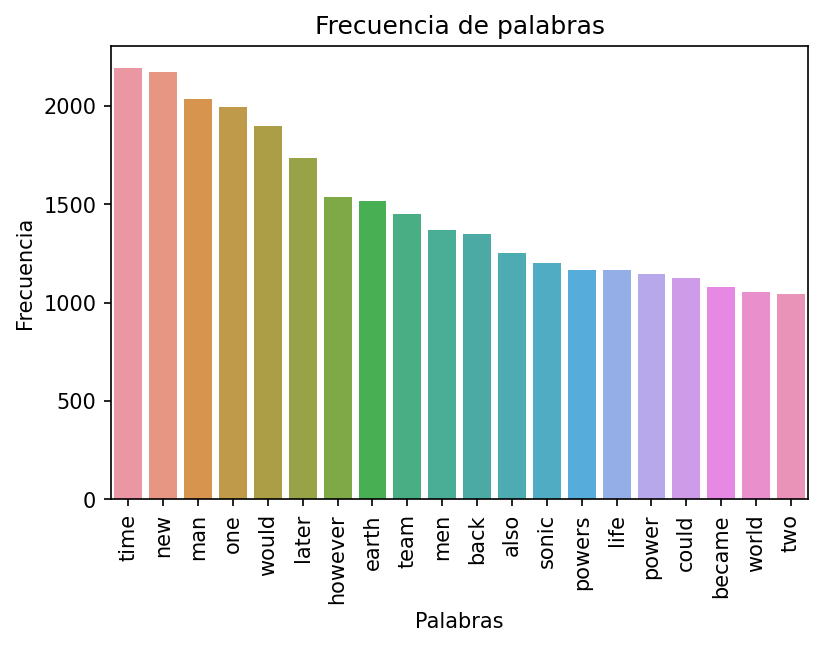

In [16]:
plt.figure(dpi=150)
sns.barplot(x="word", y="count", data=top_words[:20])
plt.ylabel("Frecuencia")
plt.xlabel("Palabras")
plt.title("Frecuencia de palabras")
plt.xticks(rotation=90)
plt.show()

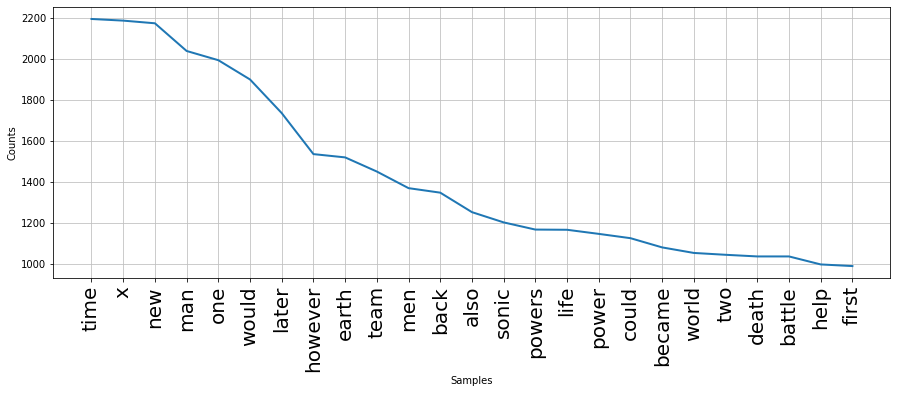

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [17]:
# nltk también ofrece una forma de obtener la frecuencia de las palabras
tokenizer = RegexpTokenizer(r'\w+')
pow_tokens = tokenizer.tokenize(' '.join(df_txt.history_text.str.lower()))

pow_tokens = [token for token in pow_tokens if token not in stop_words]

pow_freq_dist = nltk.FreqDist(pow_tokens)
plt.figure(figsize=(15, 5))
plt.xticks(fontsize=20)
pow_freq_dist.plot(25)

AUC CV score: 0.718075387270574
AUC CV score : 0.718075387270574


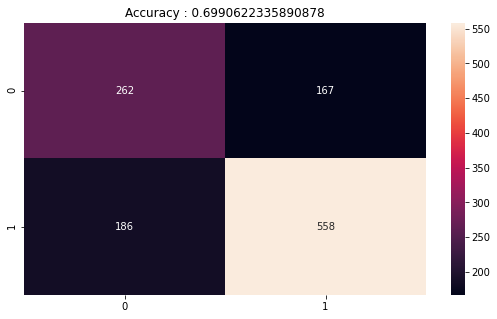

In [18]:
cv, pred = helper(df_count_vec, df_txt.alignment, MultinomialNB())
print("AUC CV score:", cv)
count_acc_mnb, count_auc_cv_mnb = plotting_helper(cv, pred, df_txt.alignment.values)

### Otra opción

In [19]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.rt = RegexpTokenizer(r'\w+')

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in self.rt.tokenize(doc)]


vect = CountVectorizer()
lemm = LemmaTokenizer()
stop_words_new = list(chain.from_iterable(lemm(word) for word in stop_words))

count_vec_lemm = CountVectorizer(
    stop_words=stop_words_new, tokenizer=lemm, ngram_range=(2, 2)
)
count_vec_lemm.fit(df_txt['history_text'].values.tolist())
df_count_vec_lemm = count_vec_lemm.transform(df_txt['history_text'].values.tolist())
df_count_vec_lemm.shape

/opt/hostedtoolcache/Python/3.7.10/x64/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(1173, 342211)

In [20]:
# Palabras por frecuencia de aparicion
top_words = pd.Series(
    df_count_vec_lemm.toarray().sum(axis=0), index=count_vec_lemm.get_feature_names()
).sort_values(ascending=False)
top_words.index.name = 'word'
top_words = top_words.to_frame('count').reset_index()
top_words.head(10)

,word,count
0,x men,1137
1,spider man,592
2,new york,328
3,iron man,295
4,captain america,274
5,h e,224
6,wonder woman,213
7,e l,210
8,big bos,209
9,justice league,200


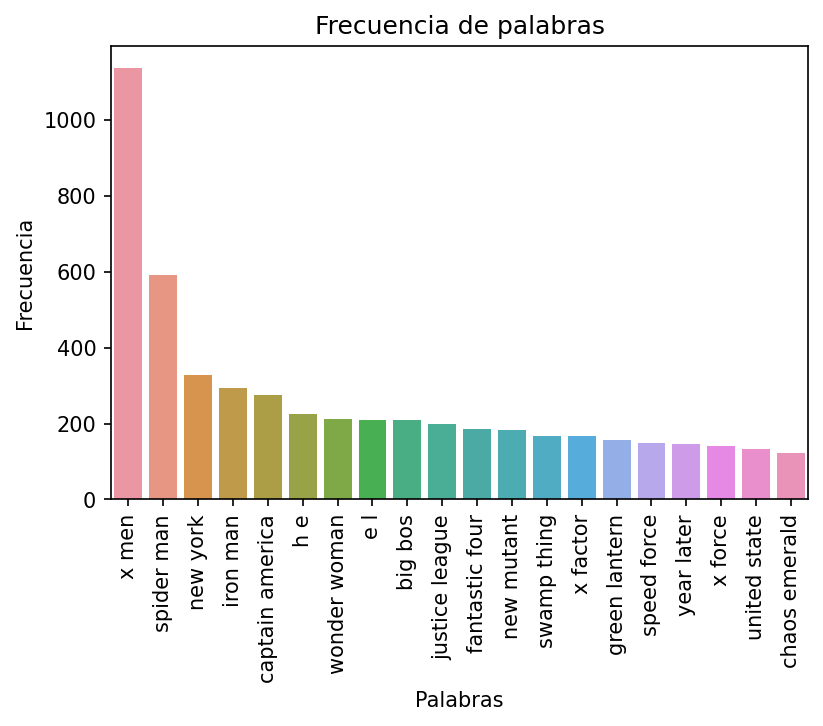

In [21]:
plt.figure(dpi=150)
sns.barplot(x="word", y="count", data=top_words[:20])
plt.ylabel("Frecuencia")
plt.xlabel("Palabras")
plt.title("Frecuencia de palabras")
plt.xticks(rotation=90)
plt.show()

AUC CV score: 0.5529482031899912
AUC CV score : 0.5529482031899912


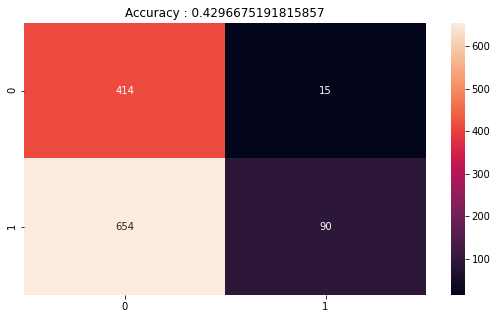

In [22]:
cv_lemm, pred_lemm = helper(df_count_vec_lemm, df_txt.alignment, MultinomialNB())
print("AUC CV score:", cv_lemm)
count_acc_mnb, count_auc_cv_mnb = plotting_helper(
    cv_lemm, pred_lemm, df_txt.alignment.values
)

### Cómo aplicamos TF-IDF

Como vimos antes CountVectorizer nos devuelve la cantidad de apariciones de cada palabra en un documento. De esta forma, nos devuelve la _frecuencia_ de cada palabra.

In [23]:
# Al resultado de CountVectorizer le aplicamos TfidfTransformer para obtener el valor de TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(df_count_vec)
tf_idf_vector = tfidf_transformer.transform(df_count_vec)

print(tf_idf_vector.toarray().shape)
print()
print(tf_idf_vector.toarray())

(1173, 27536)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
first_document_vector = tf_idf_vector[0]

# Imprimimos el resultado para el primer documento
df = pd.DataFrame(
    first_document_vector.T.todense(),
    index=count_vec.get_feature_names(),
    columns=["tfidf"],
)
df.sort_values(by=["tfidf"], ascending=False)

,tfidf
garrett,0.428016
tremont,0.371022
disabused,0.196303
delroy,0.196303
steroids,0.196303
...,...
festival,0.000000
festering,0.000000
fervor,0.000000
fertile,0.000000


In [25]:
df_txt.loc[0]['history_text']

"Delroy Garrett, Jr. grew up to become a track star and competed in the Olympic Games. After he tested positive for steroids, he lost his three gold medals. In despair, he turned to religion, specifically the Triune Understanding. This group's founder, Jonathan Tremont, had found one of three fragments of a mysterious object and used it to give Garrett the powers of 3-D Man. Garrett assumed that his powers were because of his newfound spiritual enlightenment, and Tremont never disabused him of the notion."

Vemos que las palabras que tienen valor 0 son las que no se encuentran en el documento al que hace referencia el vector.
Mientras menos común sea la palabra en nuestro corpus, mayor puntaje va a tener.

In [26]:
# Otra opción es usar directamente TfidfVectorizer que es el equivalente a usar CountVectorizer + TfidfTransformer

tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), stop_words=stop_words)
tfidf_vec.fit(df_txt['history_text'].values.tolist())
df_tfidf_vec = tfidf_vec.transform(df_txt['history_text'].values.tolist())

print(df_tfidf_vec.toarray().shape)
print()
print(df_tfidf_vec.toarray())

(1173, 27536)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [27]:
df_tfidf_first_document_vector = df_tfidf_vec[0]

# Imprimimos el resultado para el primer documento
df = pd.DataFrame(
    df_tfidf_first_document_vector.T.todense(),
    index=tfidf_vec.get_feature_names(),
    columns=["tfidf"],
)
df.sort_values(by=["tfidf"], ascending=False)

,tfidf
garrett,0.428016
tremont,0.371022
disabused,0.196303
delroy,0.196303
steroids,0.196303
...,...
festival,0.000000
festering,0.000000
fervor,0.000000
fertile,0.000000


AUC CV score: 0.7408494205220654
AUC CV score : 0.7408494205220654


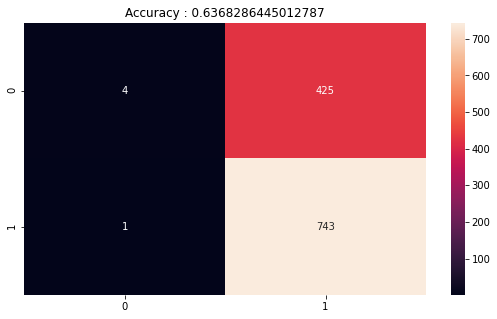

In [28]:
cv, pred = helper(df_tfidf_vec, df_txt.alignment, MultinomialNB())
print("AUC CV score:", cv)
count_acc_mnb, count_auc_cv_mnb = plotting_helper(cv, pred, df_txt.alignment.values)